In [2]:
import pandas as pd 
import spacy
from tqdm import trange
from spacy_conll import ConllFormatter
from conllu import parse
from supar import Parser
import pickle 
import numpy as np
import math 
from minicons import scorer
from collections import defaultdict
import os 
from tqdm import tqdm
from utils.variables import *
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from n_gram_calculations_dep import conllu2sen_modified, conllu2sen, load_pickled_deps_dict

/Users/frapadovani/Desktop/childes_vs_wiki/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [214]:
# -----------------------------
# Extract Features for Regression
# -----------------------------


def extract_nsubj_and_verb_fr(tokenlist, paradigm = None):
    """Extract subject (nsubj), root verb, and copula if present."""
    nsubj, root_verb, cop_verb = None, None, None
    nsubj_upos, root_upos = None, None 

    # Identify ROOT and COP verbs
    for token in tokenlist:
        if token['deprel'] == 'ROOT':
            root_verb = token['form']
            root_upos = token['upostag']
        elif token['deprel'] == 'cop':
            cop_verb = token['form']

    # Find the nsubj
    for token in tokenlist:
        if token['deprel'] == 'nsubj':  # Subject
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break
        elif token['deprel'] == 'nn':
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break

        elif token['deprel'] == 'amod':
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break

    # If the paradigm is "obj_rel_across_anim", return UPOS tags
    if paradigm == "obj_rel_across_anim":
        verb_pair = cop_verb if cop_verb else root_verb
        return nsubj, verb_pair, nsubj_upos, root_upos

    # If there's a copula, return it as well
    verb_pair = f"{cop_verb} {root_verb}" if cop_verb else root_verb

    return nsubj, verb_pair


def extract_nsubj_and_verb_and_fr(tokenlist):
    nsubj, verb1 , verb2 = None, None, None
    and_id = 0
    for token in tokenlist:
        if token['deprel'] == 'cc':
            and_id = token['id']
        if token['deprel'] == 'nsubj':
            nsubj = token['form']
    
    
    for token in tokenlist:
        if token['id'] < and_id:
            if token['deprel'] == 'ROOT':
                verb1 = token['form']
            elif token['deprel'] == 'cop':
                verb1 = token['form']
                break

    for token in tokenlist:
        if token['id'] > and_id:
            if token['deprel'] == 'conj':
                verb2 = token['form']
            elif token['deprel'] == 'cop':
                verb2 = token['form']
                break
    
    verb_pair = f"{verb1} {verb2}" if verb2 else verb1

    return nsubj, verb_pair


In [215]:
# -----------------------------
# Extract Features for Regression
# -----------------------------


def extract_nsubj_and_verb_eng_de(tokenlist, paradigm = None):
    """Extract subject (nsubj), root verb, and copula if present."""
    nsubj, root_verb, cop_verb = None, None, None
    nsubj_upos, root_upos = None, None 

    # Identify ROOT and COP verbs
    for token in tokenlist:
        if token['deprel'] == 'root':
            root_verb = token['form']
            root_upos = token['upostag']
        elif token['deprel'] == 'cop':
            cop_verb = token['form']

    # Find the nsubj
    for token in tokenlist:
        if token['deprel'] == 'nsubj':  # Subject
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break
        elif token['deprel'] == 'nn':
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break

        elif token['deprel'] == 'amod':
            nsubj = token['form']
            nsubj_upos = token['upostag']
            break

    # If the paradigm is "obj_rel_across_anim", return UPOS tags
    if paradigm == "obj_rel_across_anim":
        verb_pair = cop_verb if cop_verb else root_verb
        return nsubj, verb_pair, nsubj_upos, root_upos

    # If there's a copula, return it as well
    verb_pair = f"{cop_verb} {root_verb}" if cop_verb else root_verb

    return nsubj, verb_pair


def extract_nsubj_and_verb_and_eng_de(tokenlist):
    nsubj, verb1 , verb2 = None, None, None
    and_id = 0
    for token in tokenlist:
        if token['deprel'] == 'cc':
            and_id = token['id']
        if token['deprel'] == 'nsubj':
            nsubj = token['form']
    
    
    for token in tokenlist:
        if token['id'] < and_id:
            if token['deprel'] == 'root':
                verb1 = token['form']
            elif token['deprel'] == 'cop':
                verb1 = token['form']
                break

    for token in tokenlist:
        if token['id'] > and_id:
            if token['deprel'] == 'conj':
                verb2 = token['form']
            elif token['deprel'] == 'cop':
                verb2 = token['form']
                break
    
    verb_pair = f"{verb1} {verb2}" if verb2 else verb1

    return nsubj, verb_pair


In [216]:
# -----------------------------
# Log Frequency Calculations
# -----------------------------

SMOOTHING_CONSTANT = 1

##this is just for the frequency of bare words (unigrams)
def log_freq_unigram(item, unigram_df):
    matched_row = unigram_df[unigram_df['word'] == item]
    
    if matched_row.empty:
        not_log_count = 0  
        count = math.log(SMOOTHING_CONSTANT)
    else:
        not_log_count = matched_row['count'].iloc[0]
        if not_log_count == 1:
            count = math.log(1.5)
        else:
            count = math.log(not_log_count)
    
    return not_log_count, count


##this is just for the frequency of bare words (bigrams)
def log_freq_bigram(item1, item2, bigram_df):
    matched_row = bigram_df[(bigram_df['word1'] == item1) & (bigram_df['word2'] == item2)]

    if matched_row.empty:
        not_log_count = 0  
        count = math.log(SMOOTHING_CONSTANT)  
    else:
        not_log_count = matched_row['count'].iloc[0]
        if not_log_count == 1:
            count = math.log(1.5)
        else:
            count = math.log(not_log_count)

    return not_log_count, count


##this is for the frequency of bare words (unigrams) and their dependency relations
def log_freq_unigram_deprel(item, dep, unigram_df):
    
    matched_row = unigram_df[(unigram_df['form'] == item) & (unigram_df['deprel'] == dep)]
    
    if matched_row.empty:
        not_log_count = 0  
        count = math.log(SMOOTHING_CONSTANT) 
    else:
        not_log_count = matched_row['count'].iloc[0]
        if not_log_count == 1:
            count = math.log(1.5)
        else:
            count = math.log(not_log_count)
    
    return not_log_count, count



##this is for the frequency of bare words (bigrams) and their dependency relations
def log_freq_bigram_deprel(item1, item2, dep1, dep2, bigram_df):
    matched_row = bigram_df[(bigram_df['form_pair'] == f"{item1} -> {item2}") & (bigram_df['deprel_pair'] == f"{dep1} -> {dep2}")]

    if matched_row.empty:
        not_log_count = 0  
        count = math.log(SMOOTHING_CONSTANT) 
    else:
        not_log_count = matched_row['count'].iloc[0]
        if not_log_count == 1:
            count = math.log(1.5)
        else:
            count = math.log(not_log_count)

    return not_log_count, count



In [217]:
def transform_childes_score_file_1(df):
    new_rows = []
    
    for i in range(0, len(df), 2):
        if i + 1 >= len(df):
            break
        
        row1 = df.iloc[i]
        row2 = df.iloc[i + 1]

        delta_42 = row1['42_logp'] - row2['42_logp']
        delta_13 = row1['13_logp'] - row2['13_logp']
        delta_30 = row1['30_logp'] - row2['30_logp']
        
        new_row = {
            'minimal_pair': f"{row1['sentences']}, {row2['sentences']}",
            'paradigm': row1['paradigm'],
            'delta_score_42': delta_42,
            'delta_score_13': delta_13,
            'delta_score_30': delta_30,
            'delta_avg': (delta_42 + delta_13 + delta_30) / 3,
        }
        
        new_rows.append(new_row)
    
    return pd.DataFrame(new_rows)

In [ ]:
def score_dataset_with_models(dataset_path, model_names, output_suffix='_scored.csv', model_dir=TRAINED_MODELS):

    df = pd.read_csv(dataset_path, header=None)
    sentences = df.iloc[:, 0]
    df['sentences'] = sentences
    df['paradigm'] = ['simple_agrmt'] * len(sentences)


    def extract_verb(sentence):
        tokens = sentence.split()
        return tokens[-1]

    for model_name in model_names:
        model_path = os.path.join(model_dir, model_name)
        model_id = model_name.split('/')[0].split('_')[3]

        tokenizer = AutoTokenizer.from_pretrained(model_path)
        lm = scorer.IncrementalLMScorer(model_path, 'cpu')

        tqdm.pandas(desc=f"Scoring {model_id}")

        def score_verb_given_context(sentence):
            verb = extract_verb(sentence)
            
            verb_index = sentence.index(verb)
            context = sentence[:verb_index].strip()

            context_len = len(tokenizer.tokenize(context))
            verb_len = len(tokenizer.tokenize(" " + verb))
            verb_span = slice(context_len, context_len + verb_len)

            tokens_prob = lm.token_score(sentence)
            tokens_prob = tokens_prob[0][verb_span]
            return sum([x[1] for x in tokens_prob])

        df[model_id + '_logp'] = sentences.progress_apply(score_verb_given_context)

    output_path = './regressions_files/' + dataset_path.split('/')[-3] + dataset_path.split('/')[-2] + '_' + dataset_path.split('/')[-1].replace('.csv', output_suffix)
    df = df.iloc[:, 1:]  # Remove the original index column
    df.to_csv(output_path, index=False)
    return df


### ENGLISH

In [250]:
# CHILDES
childes_path = os.path.join(FITCLAMS_DIR, 'en_/childes/simple_agrmt.csv')
childes_models = [
    'en_child_clm_13_new/checkpoint-48000',
    'en_child_clm_30_new/checkpoint-48000',
    'en_child_clm_42_new/checkpoint-48000'
]
df_childes = score_dataset_with_models(childes_path, childes_models)


# WIKI
wiki_path = os.path.join(FITCLAMS_DIR, 'en_/wiki/simple_agrmt.csv')
wiki_models = [
    'en_wiki_clm_13_new/checkpoint-64000',
    'en_wiki_clm_30_new/checkpoint-64000',
    'en_wiki_clm_42_new/checkpoint-64000'
]
df_wiki = score_dataset_with_models(wiki_path, wiki_models)

Scoring 42: 100%|██████████| 400/400 [00:02<00:00, 198.09it/s]


In [248]:
simple_agrm_aprile_childes_eng = transform_childes_score_file_1(df_childes)
simple_agrm_aprile_wiki_eng = transform_childes_score_file_1(df_wiki)

In [225]:
def load_docs_from_paradigms(base_subdir, clams_file, lang='eng'):
    clams_path = os.path.join(PARSED_DATASETS, base_subdir, clams_file)
    paradigms = [f for f in os.listdir(clams_path) if f != '.DS_Store']
    
    docs = []
    for pickle_file in paradigms:
        parad = '_'.join(pickle_file.split('_')[2:-2])
        new_docs = load_pickled_deps_dict(
            'clams', parad, lang, 1, base_dir=os.path.join(PARSED_DATASETS, base_subdir)
        )
        docs.extend((ele, new_docs[ele], parad) for ele in new_docs)
    return docs

In [231]:

docs_childes_eng = load_docs_from_paradigms('fit_clams/childes/pickle/', 'clams_eng_deps', 'eng')
docs_wiki_eng = load_docs_from_paradigms('fit_clams/wiki/pickle/', 'clams_eng_deps', 'eng')

Loading clams eng dependencies into dictionary: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


In [257]:
def generate_minimal_pairs(docs, source_name, language):
    minimal_pairs = []

    if language == 'fr':
        keys = [doc[0].lower().strip(' .').replace("l' ", "l'") for doc in docs]
    else: 
        keys = [doc[0] for doc in docs]

    values = [doc[1] for doc in docs]
    paradigms = [doc[2] for doc in docs]

    for i in range(0, len(keys) - 1, 2):
        (grammatical_sen, grammatical_tokens), (ungrammatical_sen, ungrammatical_tokens) = \
            (keys[i], values[i]), (keys[i + 1], values[i + 1])
        paradigm = paradigms[i]

        if language == 'fr':
            extract_nsubj_and_verb = {
                'long_vp_coord': extract_nsubj_and_verb_and_fr,
                'vp_coord': extract_nsubj_and_verb_and_fr,
                'simple_agrmt': extract_nsubj_and_verb_fr,
                'simple_agrmt_new': extract_nsubj_and_verb_fr,
                'prep_anim': extract_nsubj_and_verb_fr,
                'subj_rel': extract_nsubj_and_verb_fr,
                'obj_rel_within_anim': extract_nsubj_and_verb_fr,
                'obj_rel_across_anim': extract_nsubj_and_verb_fr,
            }
        else:  
            extract_nsubj_and_verb = {
                'long_vp_coord': extract_nsubj_and_verb_and_eng_de,
                'vp_coord': extract_nsubj_and_verb_and_eng_de,
                'simple_agrmt': extract_nsubj_and_verb_eng_de,
                'simple_agrmt_new': extract_nsubj_and_verb_eng_de,
                'prep_anim': extract_nsubj_and_verb_eng_de,
                'subj_rel': extract_nsubj_and_verb_eng_de,
                'obj_rel_within_anim': extract_nsubj_and_verb_eng_de,
                'obj_rel_across_anim': extract_nsubj_and_verb_eng_de,
            }

        # Use the appropriate extraction function for this paradigm
        if paradigm in ['long_vp_coord', 'vp_coord']:
            nsubj, verb1 = extract_nsubj_and_verb[paradigm](grammatical_tokens)
            nsubj2, verb2 = extract_nsubj_and_verb[paradigm](ungrammatical_tokens)

        elif paradigm in ['simple_agrmt', 'simple_agrmt_new', 'prep_anim', 'subj_rel', 'obj_rel_within_anim']:
            nsubj, verb1 = extract_nsubj_and_verb[paradigm](grammatical_tokens)
            nsubj2, verb2 = extract_nsubj_and_verb[paradigm](ungrammatical_tokens)

        elif paradigm == 'obj_rel_across_anim':
            nsubj, verb1, nsubj_upos, root_upos = extract_nsubj_and_verb[paradigm](grammatical_tokens, paradigm=paradigm)
            nsubj2, verb2, nsubj2_upos, verb2_upos = extract_nsubj_and_verb[paradigm](ungrammatical_tokens, paradigm=paradigm)

            # English-specific adjustment (only for English)
            if language == 'en':
                if root_upos == 'NOUN':
                    nsubj = verb1
                    if verb2_upos != 'NOUN':
                        if verb2.endswith('s'):
                            verb1 = verb2[:-1]
                        else:
                            verb1 = verb2 + 's'
                    else:
                        if root_upos != 'NOUN':
                            if verb1.endswith('s'):
                                verb2 = verb1[:-1]
                            else:
                                verb2 = verb1 + 's'

        pair_string = f"{grammatical_sen}, {ungrammatical_sen}"

        minimal_pairs.append((pair_string, source_name, paradigm, nsubj, nsubj2, verb1, verb2))

    return minimal_pairs

In [259]:
minimal_pairs_childes_eng = generate_minimal_pairs(docs_childes_eng, "childes", 'en')
minimal_pairs_wiki_eng = generate_minimal_pairs(docs_wiki_eng, "wiki", 'en')

In [261]:

minimal_pairs_childes_eng = pd.DataFrame(minimal_pairs_childes_eng, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])
minimal_pairs_wiki_eng = pd.DataFrame(minimal_pairs_wiki_eng, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])

In [262]:
childes_simple_agreement_eng = minimal_pairs_childes_eng[minimal_pairs_childes_eng['paradigm'] == 'simple_agrmt']
wiki_simple_agreement_eng = minimal_pairs_wiki_eng[minimal_pairs_wiki_eng['paradigm'] == 'simple_agrmt']

In [ ]:
#'bigram_freq_gramm', 'bigram_freq_ungramm', 'bigram_nsubj_root1', 'bigram_nsubj_root2'
columns_to_initialize = ['delta_sent_length_char','delta_subwords','total_freq_verbs','total_freq_nouns','nsubj1_log_freq','nsubj2_log_freq','nsubj1_nsubj2_log_freq', 'verb_log_freq',
    'dep_nsubj1_freq', 'dep_nsubj2_freq','dep_verb_freq', 'bigram_freq_gramm', 'bigram_freq_ungramm', 'bigram_nsubj_root1', 'bigram_nsubj_root2',
]
childes_simple_agreement_eng[columns_to_initialize] = 0.0 
wiki_simple_agreement_eng[columns_to_initialize] = 0.0

In [264]:

unigram_dfs_eng = {
    'wiki': pd.read_csv(UNIGRAM_WIKI_ENG),
    'childes': pd.read_csv(UNIGRAM_CHILDES_ENG)
}

bigram_dfs_eng = {
    'wiki': pd.read_csv('./n_grams_frequency/eng/wikipedia/bigram/bigram_freq_wikipedia.csv'),
    'childes': pd.read_csv('./n_grams_frequency/eng/childes/bigram/bigram_freq_childes.csv')
}

unigram_deprel_dfs = {
    'wiki': pd.read_csv(UNIGRAM_DEP_WIKI_ENG),
    'childes': pd.read_csv(UNIGRAM_DEP_CHILDES_ENG)
}

bigram_deprel_dfs = {
    'wiki': pd.read_csv('./n_grams_frequency/eng/parsed_frequency_wiki/bigrams_deprel_freq.csv'),
    'childes': pd.read_csv('./n_grams_frequency/eng/parsed_frequency_childes/bigrams_deprel_freq.csv')
}

In [265]:
verb_map = {}
reverse_verb_map = {}

def update_verb_maps(df):
    for i in range(0, len(df) - 1, 2):
        even_row = df.iloc[i]
        odd_row = df.iloc[i + 1]

        key = even_row["verb1"]
        value = odd_row["verb1"]

        verb_map[key] = value
        reverse_verb_map[value] = key

# Apply to both datasets
update_verb_maps(childes_simple_agreement_eng)
update_verb_maps(wiki_simple_agreement_eng)

In [292]:
def compute_features(row, language, dataset, checkpoint_seeds, verb_map, reverse_verb_map):
    grammatical, ungrammatical = row['minimal_pair'].split(', ')[0], row['minimal_pair'].split(', ')[1]
    nsubj1 = row['nsubj1']
    nsubj2 = row['nsubj2']
    verb1 = row['verb1']
    paradigm = row['paradigm']

    # Determine verb2 as before
    if verb1 in verb_map:
        verb2 = verb_map[verb1]
    else:
        verb2 = reverse_verb_map[verb1]

    # Select dataset-specific resources
    if dataset == 'wiki':
        unigram_df = unigram_dfs_eng['wiki']
        bigram_df = bigram_dfs_eng['wiki']
        unigram_deprel = unigram_deprel_dfs['wiki']
        bigram_deps = bigram_deprel_dfs['wiki']
        # Compose model paths based on language, dataset and seeds
        models = [
            f"{TRAINED_MODELS}/{language}_wiki_clm_{seed}_new/checkpoint-{checkpoint_seeds['wiki']}"
            for seed in checkpoint_seeds.get('seeds', [42, 30, 13])
        ]

    elif dataset == 'childes':
        unigram_df = unigram_dfs_eng['childes']
        bigram_df = bigram_dfs_eng['childes']
        unigram_deprel = unigram_deprel_dfs['childes']
        bigram_deps = bigram_deprel_dfs['childes']
        models = [
            f"{TRAINED_MODELS}/{language}_child_clm_{seed}_new/checkpoint-{checkpoint_seeds['childes']}"
            for seed in checkpoint_seeds.get('seeds', [42, 30, 13])
        ]
    else:
        return row

    # Load tokenizer from first model path
    tokenizer = AutoTokenizer.from_pretrained(models[0])

    # Rest of your logic unchanged, e.g. tokenize, compute frequencies, etc.
    subword_gram = tokenizer(grammatical, return_tensors='pt', padding=True, truncation=True)
    subword_ungram = tokenizer(ungrammatical, return_tensors='pt', padding=True, truncation=True)
    delta_subwords = subword_gram['input_ids'].shape[1] - subword_ungram['input_ids'].shape[1]


    # Compute log frequencies
    count_freq_noun1, log_freq_noun1 = log_freq_unigram(nsubj1, unigram_df)
    _, dep_subj_freq1 = log_freq_unigram_deprel(nsubj1, 'nsubj', unigram_deprel)
    count_freq_noun2, log_freq_noun2 = log_freq_unigram(nsubj2, unigram_df)
    _, dep_subj_freq2 = log_freq_unigram_deprel(nsubj2, 'nsubj', unigram_deprel)

    # Compute verb1 and verb2 log frequencies
    def compute_verb_features(nsubj, verb, deprel):
        if ' ' in verb:
            verb_root = verb.split(' ')[0]  # Extract main verb
        else:
            verb_root = verb
        count_freq_vp, log_freq_vp = log_freq_unigram(verb_root, unigram_df)
        _,log_freq_vp_bigram = log_freq_bigram(nsubj, verb_root, bigram_df)
        _,dep_verb_freq = log_freq_unigram_deprel(verb_root, deprel, unigram_deprel)
        _,log_dep_bigram = log_freq_bigram_deprel(nsubj, verb_root, 'nsubj', 'root', bigram_deps)
        return count_freq_vp, log_freq_vp, log_freq_vp_bigram, dep_verb_freq, log_dep_bigram
    


    if paradigm in ['long_vp_coord', 'vp_coord']:
        if verb1 == None or verb2 == None:
            print(row)
            return row
        ##there are two subj-verb agreements both for grammatical and ungrammatical sentences
        verb1_1 = verb1.split(' ')[0]
        verb1_2 = verb1.split(' ')[1]
        verb2_1 = verb2.split(' ')[0]
        verb2_2 = verb2.split(' ')[1]
        count_freq_vp11, log_freq_vp1_1, log_freq_vp_bigram1_1, dep_verb1_freq1_1, log_dep_bigram1_1 = compute_verb_features(nsubj1,verb1_1, 'root')
        count_freq_vp12,log_freq_vp1_2, log_freq_vp_bigram1_2, dep_verb2_freq1_2, log_dep_bigram1_2 = compute_verb_features(nsubj1, verb1_2, 'root')

        count_freq_vp21, log_freq_vp2_1, log_freq_vp_bigram2_1, dep_verb1_freq2_1,log_dep_bigram2_1 = compute_verb_features(nsubj2, verb2_1, 'root')
        count_freq_vp22, log_freq_vp2_2, log_freq_vp_bigram2_2, dep_verb2_freq2_2, log_dep_bigram2_2 = compute_verb_features(nsubj2, verb2_2, 'root')

        log_freq_vp1 = (log_freq_vp1_1 + log_freq_vp1_2)/2
        log_freq_vp2 = (log_freq_vp2_1 + log_freq_vp2_2)/2

        log_freq_vp_bigram1 = (log_freq_vp_bigram1_1 + log_freq_vp_bigram1_2)/2
        log_freq_vp_bigram2 = (log_freq_vp_bigram2_1 + log_freq_vp_bigram2_2)/2

        dep_verb1_freq = (dep_verb1_freq1_1 + dep_verb2_freq1_2)/2
        dep_verb2_freq = (dep_verb1_freq2_1 + dep_verb2_freq2_2)/2

        log_dep_bigram1 = (log_dep_bigram1_1 + log_dep_bigram1_2)/2
        log_dep_bigram2 = (log_dep_bigram2_1 + log_dep_bigram2_2)/2
        
        
    else:
        count_freq_vp1, log_freq_vp1, log_freq_vp_bigram1, dep_verb1_freq, log_dep_bigram1 = compute_verb_features(nsubj1,verb1, 'root')
        count_freq_vp2, log_freq_vp2, log_freq_vp_bigram2, dep_verb2_freq, log_dep_bigram2 = compute_verb_features(nsubj2, verb2, 'root')
    
    count_freq_tot = log_freq_vp1 + log_freq_vp2
    count_freq_tot_noun = log_freq_noun1 + log_freq_noun2

    row['delta_sent_length_char'] = len(grammatical) - len(ungrammatical)
    row['delta_subwords'] = delta_subwords
    row['total_freq_verbs'] = count_freq_tot
    row['total_freq_nouns'] = count_freq_tot_noun
    row['nsubj1_log_freq'] = log_freq_noun1
    row['nsubj2_log_freq'] = log_freq_noun2
    row['nsubj1_nsubj2_log_freq'] = log_freq_noun1 - log_freq_noun2
    row['dep_nsubj1_freq'] = dep_subj_freq1
    row['dep_nsubj2_freq'] = dep_subj_freq2
    row['verb_log_freq'] = log_freq_vp1
    row['bigram_freq_gramm'] = log_freq_vp_bigram1
    row['bigram_freq_ungramm'] = log_freq_vp_bigram2
    row['dep_verb_freq'] = dep_verb1_freq
    row['bigram_nsubj_root1'] = log_dep_bigram1
    row['bigram_nsubj_root2'] = log_dep_bigram2

    return row

## CHILDES

In [ ]:
checkpoint_seeds = {
    'wiki': 64000,
    'childes': 48000,
    'seeds': [42, 30, 13]
}

simple_agrmt_new_clams_childes_eng = childes_simple_agreement_eng.apply(
    compute_features,
    axis=1,
    args=('en', 'childes', checkpoint_seeds, verb_map, reverse_verb_map)
)

In [ ]:
simple_agrmt_new_clams_childes_eng

,minimal_pair,dataset,paradigm,nsubj1,nsubj2,verb1,verb2,delta_sent_length_char,delta_subwords,total_freq_verbs,...,nsubj2_log_freq,nsubj1_nsubj2_log_freq,verb_log_freq,dep_nsubj1_freq,dep_nsubj2_freq,dep_verb_freq,bigram_freq_gramm,bigram_freq_ungramm,bigram_nsubj_root1,bigram_nsubj_root2
900,"the roommate awaits, the roommates awaits",childes,simple_agrmt,roommate,roommates,awaits,awaits,-1,0,0.810930,...,0.405465,0.000000,0.405465,0.000000,0.000000,0.405465,0.000000,0.000000,0.000000,0.000000
901,"the roommates await, the roommate await",childes,simple_agrmt,roommates,roommate,await,await,1,0,0.810930,...,0.405465,0.000000,0.405465,0.000000,0.000000,0.405465,0.000000,0.000000,0.000000,0.000000
902,"the roommate complains, the roommates complains",childes,simple_agrmt,roommate,roommates,complains,complains,-1,0,2.351375,...,0.405465,0.000000,0.405465,0.000000,0.000000,0.405465,0.000000,0.000000,0.000000,0.000000
903,"the roommates complain, the roommate complain",childes,simple_agrmt,roommates,roommate,complain,complain,1,0,2.351375,...,0.405465,0.000000,1.945910,0.000000,0.000000,1.791759,0.000000,0.000000,0.000000,0.000000
904,"the roommate arrives, the roommates arrives",childes,simple_agrmt,roommate,roommates,arrives,arrives,-1,0,3.178054,...,0.405465,0.000000,0.405465,0.000000,0.000000,0.405465,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,"the daddies sit, the daddy sit",childes,simple_agrmt,daddies,daddy,sit,sit,2,1,13.038947,...,8.854094,-5.635218,8.320448,1.945910,8.094684,7.906915,0.000000,0.405465,0.000000,0.405465
1096,"the daddy thinks, the daddies thinks",childes,simple_agrmt,daddy,daddies,thinks,thinks,-2,-1,14.622711,...,3.218876,5.635218,5.036953,8.094684,1.945910,4.779123,1.386294,0.000000,1.098612,0.000000
1097,"the daddies think, the daddy think",childes,simple_agrmt,daddies,daddy,think,think,2,1,14.622711,...,8.854094,-5.635218,9.585759,1.945910,8.094684,9.520909,0.000000,1.386294,0.000000,1.098612
1098,"the daddy goes, the daddies goes",childes,simple_agrmt,daddy,daddies,goes,goes,-2,-1,18.284481,...,3.218876,5.635218,8.199464,8.094684,1.945910,7.878913,2.079442,0.000000,1.791759,0.000000


In [268]:
childes_eng = simple_agrmt_new_clams_childes_eng.merge(simple_agrm_aprile_childes_eng, on=['minimal_pair', 'paradigm'], how='inner')

## WIKIPEDIA

In [ ]:
simple_agrmt_new_clams_wiki_eng = wiki_simple_agreement_eng.apply(compute_features, axis=1, args=('en', 'wiki', checkpoint_seeds, verb_map, reverse_verb_map))

In [270]:
wiki_eng = simple_agrmt_new_clams_wiki_eng.merge(simple_agrm_aprile_wiki_eng, on=['minimal_pair', 'paradigm'], how='inner')

In [ ]:
childes_eng.to_csv('./regression_analysis/regressions_files/childes_eng_1.csv', index=False)
wiki_eng.to_csv('./regression_analysis/regressions_files/wiki_eng_1.csv', index=False)

In [ ]:

# Define predictor variables
predictor_vars = ['delta_sent_length_char','delta_subwords','total_freq_verbs','total_freq_nouns','nsubj1_log_freq','nsubj2_log_freq','nsubj1_nsubj2_log_freq', 'dep_nsubj1_freq', 'dep_nsubj2_freq', 'verb_log_freq', 'dep_verb_freq'
]

# Standardize the predictor variables
scaler = StandardScaler()

#childes_min_pairs and childes features
childes_eng[predictor_vars] = scaler.fit_transform(childes_eng[predictor_vars])
wiki_eng[predictor_vars] = scaler.fit_transform(wiki_eng[predictor_vars])

In [ ]:
y = childes_eng["delta_avg"]
X_2 = sm.add_constant(childes_eng[['nsubj1_log_freq','nsubj2_log_freq']])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.649
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0732
Time:                        14:17:18   Log-Likelihood:                -413.96
No. Observations:                 200   AIC:                             833.9
Df Residuals:                     197   BIC:                             843.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2478      0.137     

In [ ]:
y = childes_eng["delta_avg"]
X_3 = sm.add_constant(childes_eng[['verb_log_freq']])

model_simple_agrmt_3 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     66.08
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.63e-14
Time:                        14:17:59   Log-Likelihood:                -387.81
No. Observations:                 200   AIC:                             779.6
Df Residuals:                     198   BIC:                             786.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2478      0.120     10.438

In [ ]:
y = childes_eng["delta_avg"]
X_4 = sm.add_constant(childes_eng[['nsubj1_log_freq','nsubj2_log_freq','verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     31.43
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.24e-16
Time:                        14:16:28   Log-Likelihood:                -377.33
No. Observations:                 200   AIC:                             762.7
Df Residuals:                     196   BIC:                             775.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2478      0.114     

In [ ]:
y = wiki_eng["delta_avg"]
X_2 = sm.add_constant(wiki_eng[['nsubj1_log_freq','nsubj2_log_freq']])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     10.37
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           5.21e-05
Time:                        14:18:47   Log-Likelihood:                -404.13
No. Observations:                 200   AIC:                             814.3
Df Residuals:                     197   BIC:                             824.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6074      0.130     

In [ ]:
y = wiki_eng["delta_avg"]
X_3 = sm.add_constant(wiki_eng[[ 'verb_log_freq']])

model_simple_agrmt_3 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01152
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.915
Time:                        14:19:14   Log-Likelihood:                -414.14
No. Observations:                 200   AIC:                             832.3
Df Residuals:                     198   BIC:                             838.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6074      0.136     11.787

In [ ]:
y = wiki_eng["delta_avg"]
X_4 = sm.add_constant(wiki_eng[['nsubj1_log_freq','nsubj2_log_freq', 'verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     6.971
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           0.000176
Time:                        14:19:21   Log-Likelihood:                -404.00
No. Observations:                 200   AIC:                             816.0
Df Residuals:                     196   BIC:                             829.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6074      0.130     

## GERMAN

In [253]:
childes_path = os.path.join(FITCLAMS_DIR,'de_/childes/simple_agrmt.csv')

model_names = [
    'de_child_clm_13_new/checkpoint-48000',
    'de_child_clm_30_new/checkpoint-48000',
    'de_child_clm_42_new/checkpoint-48000'
]


df_childes = score_dataset_with_models(childes_path, model_names, output_suffix='_scored.csv', model_dir=TRAINED_MODELS)

wiki_path = os.path.join(FITCLAMS_DIR,'de_/wiki/simple_agrmt.csv')

model_names = [
    'de_wiki_clm_13_new/checkpoint-64000',
    'de_wiki_clm_30_new/checkpoint-64000',
    'de_wiki_clm_42_new/checkpoint-64000'
]

df_wiki = score_dataset_with_models(wiki_path, model_names, output_suffix='_scored.csv', model_dir=TRAINED_MODELS)


Scoring 42: 100%|██████████| 400/400 [00:03<00:00, 126.07it/s]


In [254]:
simple_agrm_aprile_childes_de = transform_childes_score_file_1(df_childes)
simple_agrm_aprile_wiki_de = transform_childes_score_file_1(df_wiki)

In [67]:

docs_childes_new_de = load_docs_from_paradigms('fit_clams/childes/pickle/', 'clams_de_deps', 'de')
docs_wiki_new_de = load_docs_from_paradigms('fit_clams/wiki/pickle/', 'clams_de_deps', 'de')

Loading clams de dependencies into dictionary: 100%|██████████| 1/1 [00:00<00:00, 38.95it/s]


In [275]:
minimal_pairs_childes_de = generate_minimal_pairs(docs_childes_new_de, "childes", 'de')
minimal_pairs_wiki_de = generate_minimal_pairs(docs_wiki_new_de, "wiki", 'de')

In [276]:
# minimal_pairs generated by getting nouns and verbs from the distribution of childes tokens
minimal_pairs_childes_de = pd.DataFrame(minimal_pairs_childes_de, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])
minimal_pairs_wiki_de = pd.DataFrame(minimal_pairs_wiki_de, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])

In [277]:
childes_simple_agrmt_de = minimal_pairs_childes_de[minimal_pairs_childes_de['paradigm'] == 'simple_agrmt']
wiki_simple_agrmt_de = minimal_pairs_wiki_de[minimal_pairs_wiki_de['paradigm'] == 'simple_agrmt']

In [278]:
childes_simple_agreement_de = childes_simple_agrmt_de.merge(simple_agrm_aprile_childes_de, on=['minimal_pair', 'paradigm'], how='inner')
wiki_simple_agreement_de = wiki_simple_agrmt_de.merge(simple_agrm_aprile_wiki_de, on=['minimal_pair', 'paradigm'], how='inner')

In [286]:
#generate mapping of singular and plural verbs

mapping_nouns_childes = {'feind': 'feinde',
                 'feinde':'feind',
                 'architekt':'architekten',
                 'architekten':'architekt',
                 'präsident': 'präsidenten',
                 'präsidenten':'präsident',
                 'kollege': 'kollegen',
                 'kollegen':'kollege',
                 'ingenieur':'ingenieure',
                 'ingenieure':'ingenieur',
                 'sohn':'söhne',
                 'söhne':'sohn',
                 'arzt':'ärzte',
                 'ärzte':'arzt',
                 'doktor':'doktoren',
                 'doktoren':'doktor',
                 'mensch':'menschen',
                 'menschen':'mensch',
                 'frau':'frauen',
                 'frauen':'frau'
                 }

mapping_nouns_wiki = {'fahrgast':'fahrgäste',
                         'fahrgäste':'fahrgast',
                         'kleinkind': 'kleinkinder',
                         'kleinkinder':'kleinkind',
                         'zwilling':'zwillinge',
                         'polizist':'polizisten',
                          'polizisten':'polizist',
                          'kunde':'kunden',
                          'kunden':'kunde',
                          'schwester':'schwestern',
                          'schwestern':'schwester',
                          'bruder': 'brüder',
                          'brüder':'bruder',
                          'vater':'väter',
                          'väter':'vater',
                          'mann':'männer',
                          'männer':'mann',
                          'person':'personen',
                          'personen':'person'

                         }

mapping_verbs_childes = {"zweifelt": "zweifeln",
    "konstruiert": "konstruieren",
    "fürchtet": "fürchten",
    "schält": "schälen",
    "taucht": "tauchen",
    "kennt": "kennen",
    "schreibt": "schreiben",
    "erzählt": "erzählen",
    "spielt": "spielen",
    "kommt": "kommen",
    "zweifeln": "zweifelt",
    "konstruieren": "konstruiert",
    "fürchten": "fürchtet",
    "schälen": "schält",
    "tauchen": "taucht",
    "kennen": "kennt",
    "schreiben": "schreibt",
    "erzählen": "erzählt",
    "spielen": "spielt",
    "kommen": "kommt"}

mapping_verbs_wiki = {"schaukelt": "schaukeln",
    "flüchtet": "flüchten",
    "riecht": "riechen",
    "wandert": "wandern",
    "feiert": "feiern",
    "verschwindet": "verschwinden",
    "denkt": "denken",
    "spricht": "sprechen",
    "arbeitet": "arbeiten",
    "liegt": "liegen",
    "schaukeln": "schaukelt",
    "flüchten": "flüchtet",
    "riechen": "riecht",
    "wandern": "wandert",
    "feiern": "feiert",
    "verschwinden": "verschwindet",
    "denken": "denkt",
    "sprechen": "spricht",
    "arbeiten": "arbeitet",
    "liegen": "liegt"}

total_verb_mapping = {**mapping_verbs_childes, **mapping_verbs_wiki}
reverse_total_verb_mapping = {v: k for k, v in total_verb_mapping.items()}


In [287]:
from functools import partial

def fill_missing_nsubj(row, mapping_dict):
    if pd.isna(row['nsubj1']) or row['nsubj1'] == '':
        val = row['nsubj2']
        if val in mapping_dict:
            row['nsubj1'] = mapping_dict[val]
    elif pd.isna(row['nsubj2']) or row['nsubj2'] == '':
        val = row['nsubj1']
        if val in mapping_dict:
            row['nsubj2'] = mapping_dict[val]
    
    if row['verb1'] in mapping_dict:
        row['verb1'] = mapping_dict[row['verb1']]
    return row

def correct_wrong_verbs(row, mapping_dict_verbs, mapping_dict_nouns):

    if row['verb2'] in mapping_dict_nouns.keys():
        row['verb2'] = row['verb1']

    return row



In [288]:
childes_simple_agreement_de = childes_simple_agreement_de.apply(partial(fill_missing_nsubj, mapping_dict=mapping_nouns_childes), axis=1)
wiki_simple_agreement_de = wiki_simple_agreement_de.apply(partial(fill_missing_nsubj, mapping_dict=mapping_nouns_wiki), axis=1)

childes_simple_agreement_de = childes_simple_agreement_de .apply(partial(correct_wrong_verbs, mapping_dict_verbs=mapping_verbs_childes, mapping_dict_nouns=mapping_nouns_childes), axis=1)
wiki_simple_agreement_de = wiki_simple_agreement_de.apply(partial(correct_wrong_verbs, mapping_dict_verbs=mapping_verbs_wiki, mapping_dict_nouns=mapping_nouns_wiki), axis=1)


In [289]:
childes_simple_agreement_de[columns_to_initialize] = 0.0 
wiki_simple_agreement_de[columns_to_initialize] = 0.0

In [284]:

unigram_dfs_de = {
    'wiki': pd.read_csv(UNIGRAM_WIKI_DE),
    'childes': pd.read_csv(UNIGRAM_CHILDES_DE)
}

bigram_dfs_de = {
    'wiki': pd.read_csv('./n_grams_frequency/de/wikipedia/bigram/bigram_freq_wikipedia.csv'),
    'childes': pd.read_csv('./n_grams_frequency/de/childes/bigram/bigram_freq_childes.csv')
}

unigram_deprel_dfs_de = {
    'wiki': pd.read_csv(UNIGRAM_DEP_WIKI_DE),
    'childes': pd.read_csv(UNIGRAM_DEP_CHILDES_DE)
}

bigram_deprel_dfs_de = {
    'wiki': pd.read_csv('./n_grams_frequency/de/parsed_frequency_wiki/bigrams_deprel_freq.csv'),
    'childes': pd.read_csv('./n_grams_frequency/de/parsed_frequency_childes/bigrams_deprel_freq.csv')
}

In [ ]:
checkpoint_seeds = {
    'wiki': 64000,
    'childes': 48000,
    'seeds': [42, 30, 13]
}

childes_de = childes_simple_agreement_de.apply(compute_features, axis=1, args=('de', 'childes', checkpoint_seeds, total_verb_mapping, reverse_total_verb_mapping))

In [ ]:
wiki_de = wiki_simple_agreement_de.apply(compute_features, axis=1, args=('de', 'wiki', checkpoint_seeds, total_verb_mapping, reverse_total_verb_mapping))

In [ ]:
childes_de.to_csv('./regression_analysis/regressions_files/childes_de_1.csv', index=False)
wiki_de.to_csv('./regression_analysis/regressions_files/wiki_de_1.csv', index=False)

In [ ]:
# Define predictor variables
predictor_vars = ['delta_sent_length_char','delta_subwords','total_freq_verbs','total_freq_nouns','nsubj1_log_freq','nsubj2_log_freq','nsubj1_nsubj2_log_freq', 'verb_log_freq', 'dep_nsubj1_freq', 'dep_nsubj2_freq',
    'dep_verb_freq'
]

scaler = StandardScaler()

#childes_min_pairs and childes features
wiki_de[predictor_vars] = scaler.fit_transform(wiki_de[predictor_vars])
childes_de[predictor_vars] = scaler.fit_transform(childes_de[predictor_vars])

### CHILDES

In [ ]:
y = childes_de["delta_avg"]
X_2 = sm.add_constant(childes_de[['nsubj1_log_freq','nsubj2_log_freq']])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     16.66
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.06e-07
Time:                        14:33:46   Log-Likelihood:                -415.73
No. Observations:                 200   AIC:                             837.5
Df Residuals:                     197   BIC:                             847.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9373      0.138     

In [ ]:
y = childes_de["delta_avg"]
X_3 = sm.add_constant(childes_de[[ 'verb_log_freq']])

model_simple_agrmt_3 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     31.58
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           6.45e-08
Time:                        14:33:49   Log-Likelihood:                -416.57
No. Observations:                 200   AIC:                             837.1
Df Residuals:                     198   BIC:                             843.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.9373      0.138     14.035

In [ ]:
y = childes_de["delta_avg"]
X_4 = sm.add_constant(childes_de[['nsubj1_log_freq','nsubj2_log_freq', 'verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     24.47
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.71e-13
Time:                        14:33:51   Log-Likelihood:                -399.55
No. Observations:                 200   AIC:                             807.1
Df Residuals:                     196   BIC:                             820.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9373      0.127     

### WIKIPEDIA

In [ ]:
y = wiki_de["delta_avg"]
X_2 = sm.add_constant(wiki_de[["nsubj1_log_freq","nsubj2_log_freq"]])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.278
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0398
Time:                        14:34:07   Log-Likelihood:                -471.34
No. Observations:                 200   AIC:                             948.7
Df Residuals:                     197   BIC:                             958.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2784      0.182     

In [ ]:
y = wiki_de["delta_avg"]
X_3 = sm.add_constant(wiki_de[['verb_log_freq']])

model_simple_agrmt_3 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

In [ ]:
y = wiki_de["delta_avg"]
X_4 = sm.add_constant(wiki_de[["nsubj1_log_freq","nsubj2_log_freq", 'verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     7.319
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           0.000112
Time:                        14:34:33   Log-Likelihood:                -463.99
No. Observations:                 200   AIC:                             936.0
Df Residuals:                     196   BIC:                             949.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2784      0.176     

## FRENCH

In [295]:

wiki_path = os.path.join(FITCLAMS_DIR,'fr_/wiki/simple_agrmt.csv')

model_names = [
    'fr_wiki_clm_13_new/checkpoint-44000',
    'fr_wiki_clm_42_new/checkpoint-44000',
    'fr_wiki_clm_30_new/checkpoint-44000'
]


df_wiki = score_dataset_with_models(wiki_path, model_names)


childes_path = os.path.join(FITCLAMS_DIR,'fr_/childes/simple_agrmt.csv')

model_names = [
    'fr_child_clm_13_new/checkpoint-36000',
    'fr_child_clm_42_new/checkpoint-36000',
    'fr_child_clm_30_new/checkpoint-36000'
]

df_childes = score_dataset_with_models(childes_path, model_names)

Scoring 30: 100%|██████████| 252/252 [00:01<00:00, 126.80it/s]


In [296]:
simple_agrm_aprile_childes_fr = transform_childes_score_file_1(df_childes)
simple_agrm_aprile_wiki_fr = transform_childes_score_file_1(df_wiki)

In [297]:
#change the paradigm_clams directory when you are dealing with clams_new
clams_new = 'fit_clams/childes/pickle/'
paradigms_clams = os.listdir(os.path.join(PARSED_DATASETS,clams_new,'clams_fr_deps'))
docs_childes_new_fr = []
for pickle_file in paradigms_clams:
    if pickle_file != '.DS_Store':
        parad = '_'.join(pickle_file.split('_')[2:-2])
        if parad == 'simple_agrmt':
            #omly change the base_fir when you are dealing with clams_new
            new_docs = load_pickled_deps_dict('clams', parad, 'fr', 1, base_dir=os.path.join(PARSED_DATASETS,clams_new))
            for ele in new_docs:
                docs_childes_new_fr.append((ele,new_docs[ele], parad))

Loading clams fr dependencies into dictionary: 100%|██████████| 1/1 [00:37<00:00, 37.86s/it]


In [298]:
#change the paradigm_clams directory when you are dealing with clams_new
clams_new = 'fit_clams/wiki/pickle/'
paradigms_clams = os.listdir(os.path.join(PARSED_DATASETS,clams_new,'clams_fr_deps'))
docs_wiki_new_fr = []
for pickle_file in paradigms_clams:
    if pickle_file != '.DS_Store':
        parad = '_'.join(pickle_file.split('_')[2:-2])
        if parad == 'simple_agrmt':
            new_docs = load_pickled_deps_dict('clams', parad, 'fr', 1, base_dir=os.path.join(PARSED_DATASETS,clams_new))
            for ele in new_docs:
                docs_wiki_new_fr.append((ele,new_docs[ele], parad))

Loading clams fr dependencies into dictionary: 100%|██████████| 1/1 [00:00<00:00, 110.50it/s]


In [301]:
minimal_pairs_childes_fr = generate_minimal_pairs(docs_childes_new_fr, "childes", 'fr')
minimal_pairs_wiki_fr = generate_minimal_pairs(docs_wiki_new_fr, "wiki", 'fr' )

In [ ]:

minimal_pairs_childes_fr = pd.DataFrame(minimal_pairs_childes_fr, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])
minimal_pairs_wiki_fr = pd.DataFrame(minimal_pairs_wiki_fr, columns=["minimal_pair", "dataset", "paradigm", "nsubj1", "nsubj2", "verb1", "verb2"])

In [ ]:
childes_simple_agreement_fr = minimal_pairs_childes_fr[minimal_pairs_childes_fr['paradigm'] == 'simple_agrmt']
wiki_simple_agreement_fr = minimal_pairs_wiki_fr[minimal_pairs_wiki_fr['paradigm'] == 'simple_agrmt']

In [ ]:
childes_simple_agreement_fr = childes_simple_agreement_fr.merge(simple_agrm_aprile_childes_fr, on=['minimal_pair', 'paradigm'], how='inner')
wiki_simple_agreement_fr = wiki_simple_agreement_fr.merge(simple_agrm_aprile_wiki_fr, on=['minimal_pair', 'paradigm'], how='inner')

In [199]:

columns_to_initialize = ['delta_sent_length_char','delta_subwords','total_freq_verbs','total_freq_nouns','nsubj1_log_freq','nsubj2_log_freq','nsubj1_nsubj2_log_freq', 'verb_log_freq', 
                         'dep_nsubj1_freq', 'dep_nsubj2_freq','dep_verb_freq', 'bigram_freq_gramm', 'bigram_freq_ungramm', 'bigram_nsubj2_root','bigram_nsubj1_root'
]
childes_simple_agreement_fr[columns_to_initialize] = 0.0 
wiki_simple_agreement_fr[columns_to_initialize] = 0.0

In [200]:
unigram_dfs_fr = {
    'wiki': pd.read_csv(UNIGRAM_WIKI_FR),
    'childes': pd.read_csv(UNIGRAM_CHILDES_FR)
}

bigram_dfs_fr = {
    'wiki': pd.read_csv('./n_grams_frequency/fr/wikipedia/bigram/bigram_freq_wikipedia.csv'),
    'childes': pd.read_csv('./n_grams_frequency/fr/childes/bigram/bigram_freq_childes.csv')
}

unigram_deprel_dfs_fr = {
    'wiki': pd.read_csv(UNIGRAM_DEP_WIKI_FR),
    'childes': pd.read_csv(UNIGRAM_DEP_CHILDES_FR)
}

bigram_deprel_dfs_fr = {
    'wiki': pd.read_csv('./n_grams_frequency/fr/parsed_frequency_wiki/bigrams_deprel_freq.csv'),
    'childes': pd.read_csv('./n_grams_frequency/fr/parsed_frequency_childes/bigrams_deprel_freq.csv')
}

In [304]:
verb_map = {}
reverse_verb_map = {}

update_verb_maps(childes_simple_agreement_fr)
update_verb_maps(wiki_simple_agreement_fr)

In [305]:
checkpoint_seeds = {
    'wiki': 44000,
    'childes': 36000,
    'seeds': [42, 30, 13]
}

childes_simple_agreement_fr = childes_simple_agreement_fr.apply(compute_features, axis=1, args=('fr', 'childes', checkpoint_seeds, verb_map, reverse_verb_map))

In [ ]:
wiki_simple_agreement_fr = wiki_simple_agreement_fr.apply(compute_features, axis=1, args=('fr', 'wiki', checkpoint_seeds, verb_map, reverse_verb_map))

In [ ]:
childes_simple_agreement_fr.to_csv('./regression_analysis/regressions_files/childes_fr_1.csv', index=False)
wiki_simple_agreement_fr.to_csv('./regression_analysis/regressions_files/wiki_fr_1.csv', index=False)

In [206]:
# Define predictor variables
predictor_vars = ['delta_sent_length_char','delta_subwords','total_freq_verbs','total_freq_nouns','nsubj1_log_freq','nsubj2_log_freq','nsubj1_nsubj2_log_freq', 'verb_log_freq',
    'dep_nsubj1_freq', 'dep_nsubj2_freq'
]

# Standardize the predictor variables
scaler = StandardScaler()

#childes_min_pairs and childes features
wiki_simple_agreement_fr[predictor_vars] = scaler.fit_transform(wiki_simple_agreement_fr[predictor_vars])
childes_simple_agreement_fr[predictor_vars] = scaler.fit_transform(childes_simple_agreement_fr[predictor_vars])

### CHILDES

In [207]:
y = childes_simple_agreement_fr["delta_avg"]
X_2 = sm.add_constant(childes_simple_agreement_fr[['nsubj1_log_freq','nsubj2_log_freq']])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     12.52
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.12e-05
Time:                        16:34:02   Log-Likelihood:                -271.68
No. Observations:                 126   AIC:                             549.4
Df Residuals:                     123   BIC:                             557.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.0273      0.188     

In [208]:
y = childes_simple_agreement_fr["delta_avg"]
X_3 = sm.add_constant(childes_simple_agreement_fr[[ 'verb_log_freq']])

model_simple_agrmt_3 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     10.27
Date:                Tue, 03 Jun 2025   Prob (F-statistic):            0.00172
Time:                        16:34:09   Log-Likelihood:                -278.34
No. Observations:                 126   AIC:                             560.7
Df Residuals:                     124   BIC:                             566.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0273      0.198     15.298

In [209]:
y = childes_simple_agreement_fr["delta_avg"]
X_4 = sm.add_constant(childes_simple_agreement_fr[['nsubj1_log_freq','nsubj2_log_freq', 'verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     9.654
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           9.13e-06
Time:                        16:34:23   Log-Likelihood:                -269.94
No. Observations:                 126   AIC:                             547.9
Df Residuals:                     122   BIC:                             559.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.0273      0.187     

### WIKIPEDIA

In [210]:
y = wiki_simple_agreement_fr["delta_avg"]
X_2 = sm.add_constant(wiki_simple_agreement_fr[["nsubj1_log_freq","nsubj2_log_freq"]])

model_simple_agrmt_2 = sm.OLS(y, X_2).fit()
print(model_simple_agrmt_2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     5.997
Date:                Tue, 03 Jun 2025   Prob (F-statistic):            0.00327
Time:                        16:35:32   Log-Likelihood:                -255.80
No. Observations:                 126   AIC:                             517.6
Df Residuals:                     123   BIC:                             526.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.4921      0.166     

In [211]:
y = wiki_simple_agreement_fr["delta_avg"]
X_3 = sm.add_constant(wiki_simple_agreement_fr[['verb_log_freq']])

model_simple_agrmt_2 = sm.OLS(y, X_3).fit()
print(model_simple_agrmt_3.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_avg   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     10.27
Date:                Tue, 03 Jun 2025   Prob (F-statistic):            0.00172
Time:                        16:35:45   Log-Likelihood:                -278.34
No. Observations:                 126   AIC:                             560.7
Df Residuals:                     124   BIC:                             566.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0273      0.198     15.298

In [ ]:
y = wiki_simple_agreement_fr["delta_avg"]
X_4 = sm.add_constant(wiki_simple_agreement_fr[["nsubj1_log_freq","nsubj2_log_freq", 'verb_log_freq']])

model_simple_agrmt_4 = sm.OLS(y, X_4).fit()
print(model_simple_agrmt_4.summary())

### CORRELATION SCATTERPLOTS

[CHILDES - ENG] Pearson r = 0.53, p = 5.29e-16


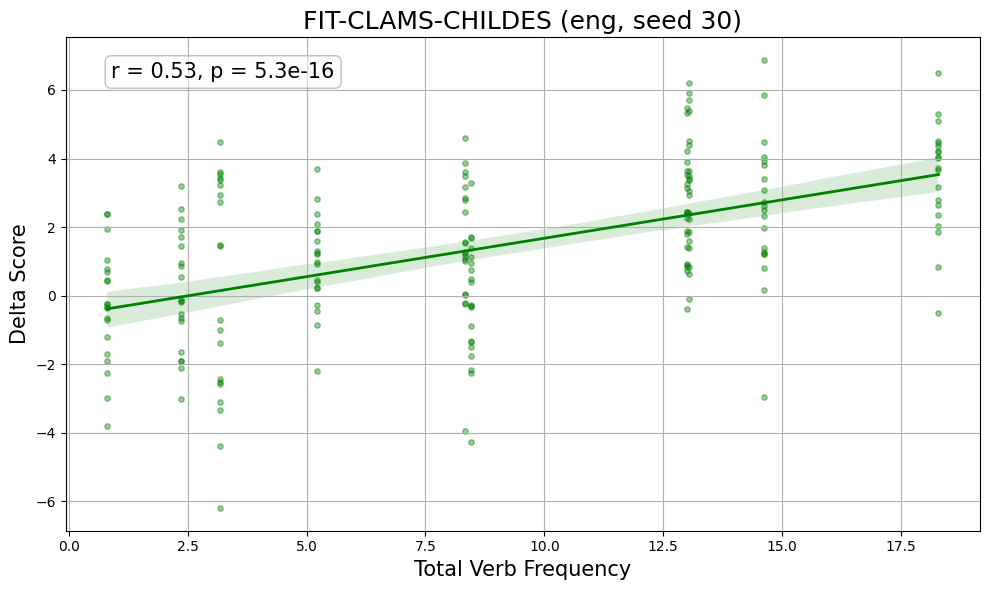

[CHILDES - FR] Pearson r = 0.20, p = 0.0252


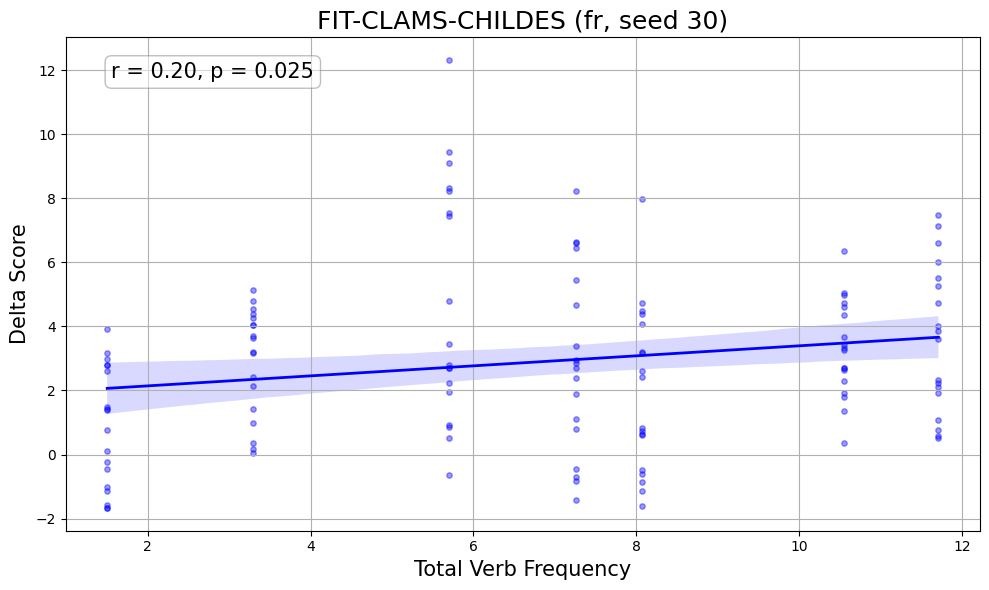

[CHILDES - DE] Pearson r = 0.31, p = 4.08e-13


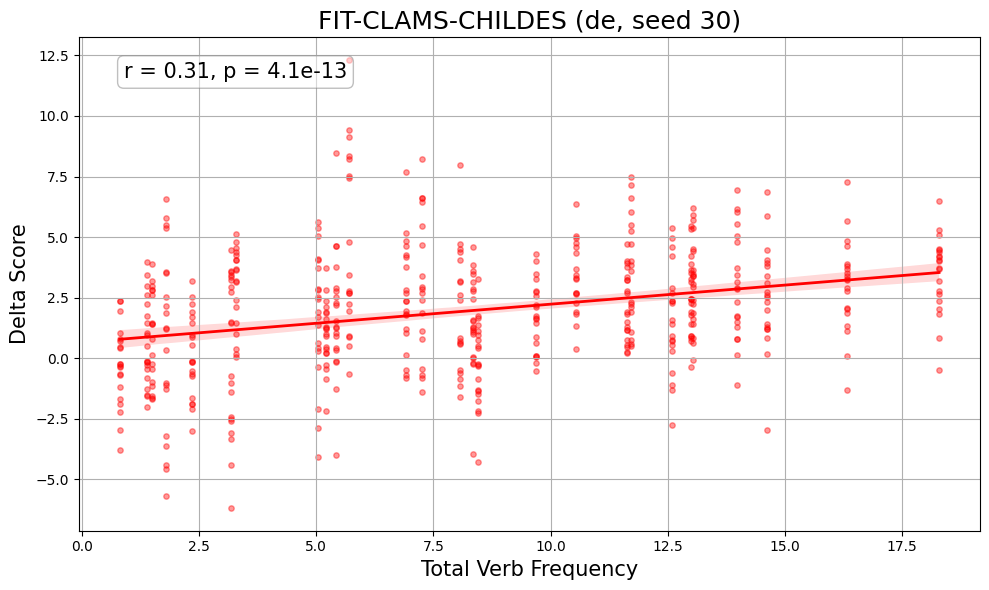

[WIKI - ENG] Pearson r = 0.06, p = 0.419


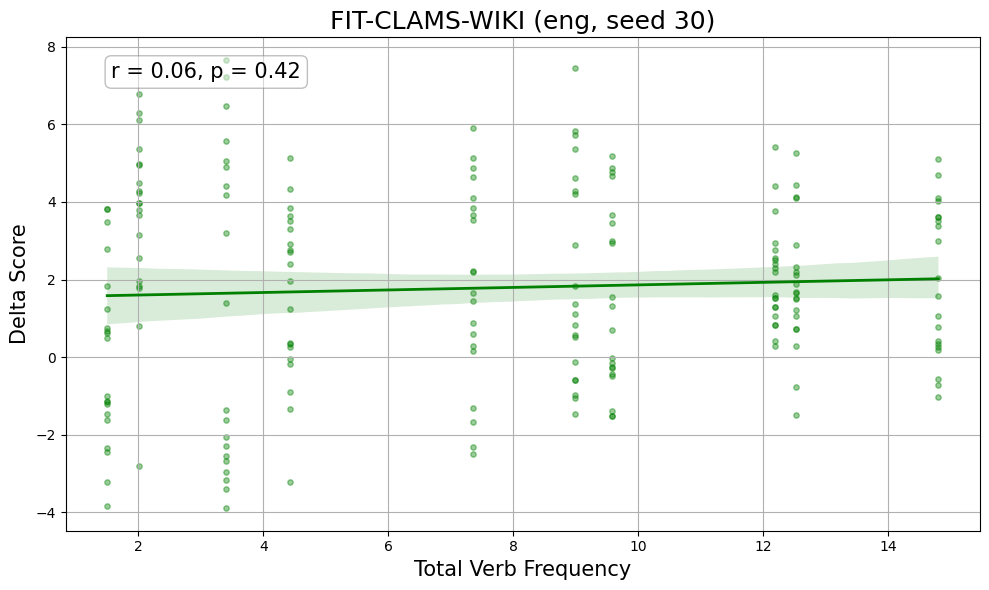

[WIKI - FR] Pearson r = 0.19, p = 0.0334


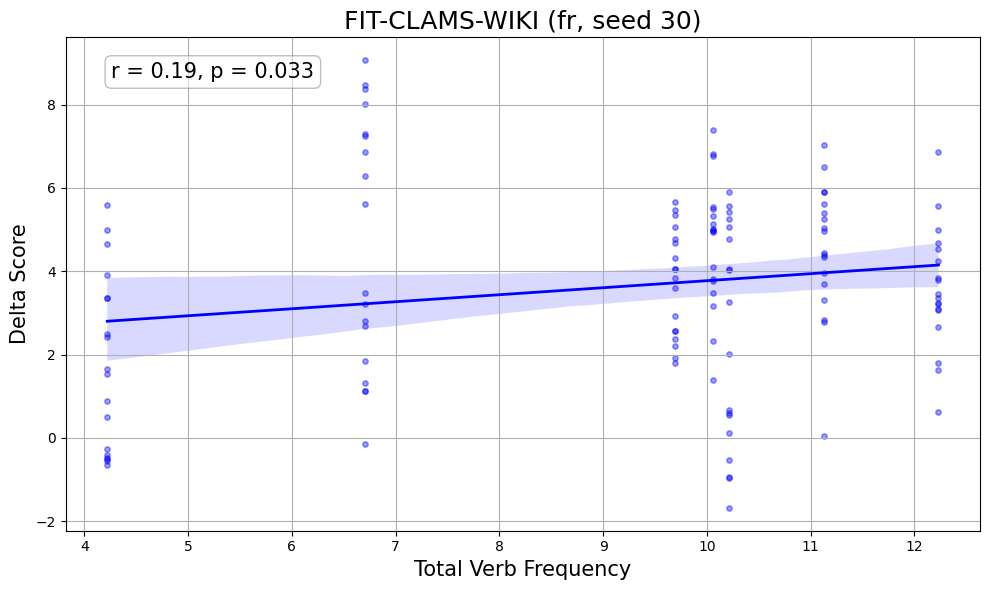

[WIKI - DE] Pearson r = 0.13, p = 0.0571


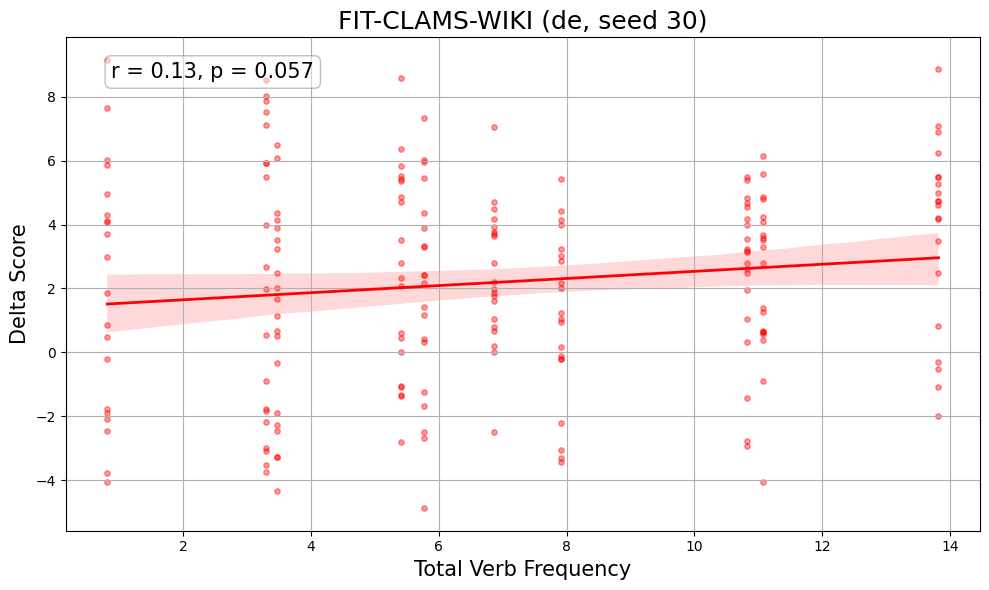

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


def generate_correlation_plot(base_folder, corpus, language, seed=30):
    """
    Generates and saves a correlation scatterplot between total verb frequency and delta score.

    Parameters:
        base_folder (str): Directory containing CSV files.
        corpus (str): 'childes' or 'wiki'.
        language (str): Language code: 'eng', 'fr', or 'de'.
        seed (int): Seed number used in the delta_score column.
    """
    # Set color per language
    language_colors = {
        'eng': 'green',
        'fr': 'blue',
        'de': 'red'
    }
    color = language_colors.get(language, 'gray')

    target_column = f"delta_score_{seed}"
    #target_column = f"delta_avg"
    dfs = []

    for filename in os.listdir(base_folder):
        if (
            filename.endswith("_1.csv") and
            corpus in filename.lower() and
            language in filename.lower()
        ):
            full_path = os.path.join(base_folder, filename)
            df = pd.read_csv(full_path)
            df = df[sorted(df.columns)]
            if target_column in df.columns:
                dfs.append(df)
    
    if not dfs:
        print(f"No matching files found for {corpus} ({language}).")
        return
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Pearson correlation
    r, pval = pearsonr(combined_df["total_freq_verbs"], combined_df[target_column])
    print(f"[{corpus.upper()} - {language.upper()}] Pearson r = {r:.2f}, p = {pval:.3g}")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=combined_df,
        x="total_freq_verbs",
        y=target_column,
        scatter=True,
        label=f"delta_seed_{seed}",
        color=color,
        scatter_kws={"alpha": 0.4, "s": 15},
        line_kws={"linewidth": 2}
    )

    plt.xlabel("Total Verb Frequency", fontsize=15)
    plt.ylabel("Delta Score", fontsize=15)
    plt.title(f"FIT-CLAMS-{corpus.upper()} ({language}, seed {seed})", fontsize=18)
    plt.grid(True)
    plt.tight_layout()

    plt.text(
        0.05, 0.95,
        f"r = {r:.2f}, p = {pval:.2g}",
        transform=plt.gca().transAxes,
        fontsize=15,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.5)
    )

    # Save as PNG
    save_path = os.path.join('/'.join(base_folder.split('/')[:-1]), 'regressions_plots', f"FIT-CLAMS_plot_{corpus}_{language}_delta{seed}.png")
    plt.savefig(save_path, format="png")
    plt.show()



# Example usage for all combinations
folder_path = './regression_analysis/regressions_files'
corpora = ['childes', 'wiki']
languages = ['eng', 'fr', 'de']

for corpus in corpora:
    for lang in languages:
        generate_correlation_plot(folder_path, corpus, lang)

In [19]:
from scipy.stats import levene
import numpy as np
import statsmodels.api as sm

def compute_residual_variance(df, x_col, y_col):
    """Fits linear model and returns residuals and their variance."""
    X = sm.add_constant(df[x_col])
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    return residuals, np.var(residuals), model.rsquared

# Container to compare variances
residual_data = {}

for corpus in corpora:
    for lang in languages:
        # Load data as in your original function
        dfs = []
        for filename in os.listdir(folder_path):
            if filename.endswith("_1.csv") and corpus in filename and lang in filename:
                df = pd.read_csv(os.path.join(folder_path, filename))
                df = df[sorted(df.columns)]
                if f"delta_score_{30}" in df.columns:
                    dfs.append(df)
        if dfs:
            combined = pd.concat(dfs, ignore_index=True)
            resids, var, r2 = compute_residual_variance(combined, 'total_freq_verbs', f"delta_score_{30}")
            key = f"{corpus}_{lang}"
            residual_data[key] = resids
            print(f"{key} | Var of residuals = {var:.4f} | R² = {r2:.2f}")

childes_eng | Var of residuals = 3.9350 | R² = 0.28
childes_fr | Var of residuals = 6.8709 | R² = 0.04
childes_de | Var of residuals = 5.6899 | R² = 0.10
wiki_eng | Var of residuals = 6.4197 | R² = 0.00
wiki_fr | Var of residuals = 4.9892 | R² = 0.04
wiki_de | Var of residuals = 9.8556 | R² = 0.02


In [20]:
print("\n--- Levene’s Test (Equal Variance across corpora) ---")
for lang in languages:
    res_childes = residual_data.get(f"childes_{lang}")
    res_wiki = residual_data.get(f"wiki_{lang}")
    if res_childes is not None and res_wiki is not None:
        stat, pval = levene(res_childes, res_wiki)
        print(f"{lang.upper()} | Levene stat = {stat:.2f}, p = {pval:.3g}")



--- Levene’s Test (Equal Variance across corpora) ---
ENG | Levene stat = 17.76, p = 3.1e-05
FR | Levene stat = 2.16, p = 0.143
DE | Levene stat = 30.76, p = 4.09e-08
